# FairPredictor XGBoost Examples
This file contains demo code for an extended version of the example in Readme.md (additionally handling more fairness over multiple groups), and enforcing a range of fairness definition on COMPAS.

It is a modified version of [quickstart_autogluon.ipynb](./quickstart_autogluon.ipynb)

FairPredictor is a postprocessing approach for enforcing fairness, with support for a wide range of performance metrics and fairness criteria, and support for inferred attributes, i.e., it does not require access to protected attributes at test time. 
Under the hood, FairPredictor works by adjusting the decision boundary for each group individually. Where groups are not available, it makes use of inferred group membership to adjust decision boundaries.

The key idea underlying this toolkit is that for a wide range of use cases, the most suitable classifier should do more than maximize some form of accuracy.
We offer a general toolkit that allows different measures to be optimized and additional constraints to be imposed by tuning the behavior of a binary predictor on validation data.

For example, classifiers can be tuned to maximize performance for a wide range of metrics such as:

* Accuracy
* Balanced Accuracy
* F1 score
* MCC
* Custom utility functions

While also approximately satisfying a wide range of group constraints such as:

* Demographic Parity (The idea that positive decisions should occur at the same rates for all protected groups, for example for men at the same rate as for women)
* Equal Opportunity (The recall should be the same for all protected groups)
* Minimum recall constraints (The recall should be above a particular level for all groups)
* Minimum Precision constraints (The precision should be above a particular level for all groups)
* Custom Fairness Metrics

The full set of constraints and objectives can be seen in Readme.md 

In [1]:
# Load and train a baseline classifier

from oxonfair import dataset_loader, FairPredictor
from oxonfair import group_metrics as gm
import xgboost
import pandas as pd
import numpy as np


train_data, val_data, test_data = dataset_loader.adult('sex')
predictor=xgboost.XGBClassifier().fit(X=train_data['data'],y=train_data['target'])

In [2]:
train_data['data'].shape,val_data['data'].shape,test_data['data'].shape

((24421, 14), (12210, 14), (12211, 14))

In [3]:
# Modify predictor to enforce fairness over the val_data with respect to groups given by the column 'sex'
fpredictor = FairPredictor(predictor,val_data, 'sex')
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy,gm.demographic_parity,0.02)


Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


In [4]:
# Evaluate on test data
fpredictor.predict(test_data)

array([0, 0, 0, ..., 1, 0, 0])

In [5]:
# Evaluate a range of performance measures, and compare against original classifier on test data
fpredictor.evaluate(test_data, verbose=True)

,original,updated
Accuracy,0.869871,0.852756
Balanced Accuracy,0.797063,0.761652
F1 score,0.707420,0.656083
MCC,0.627367,0.570455
Precision,0.765644,0.743712
Recall,0.657426,0.586927
ROC AUC,0.924595,0.821728


In [6]:
# Evaluate against a range of standard fairness definitions and compare against original classifier on test data
fpredictor.evaluate_fairness(test_data, verbose=True)

,original,updated
Statistical Parity,0.183936,0.026034
Predictive Parity,0.002504,0.336268
Equal Opportunity,0.094851,0.249449
Average Group Difference in False Negative Rate,0.094851,0.249449
Equalized Odds,0.081254,0.150011
Conditional Use Accuracy,0.044046,0.240197
Average Group Difference in Accuracy,0.096361,0.061360
Treatment Equality,0.202847,3.607847


In [7]:
# Evaluate a range of performance measures per group, and compare against original classifier on test data
fpredictor.evaluate_groups(test_data, verbose=True, return_original=True)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.869871           0.797063  0.707420  0.627367   
         0                   0.934289           0.777508  0.657216  0.629122   
         1                   0.837927           0.791104  0.715789  0.605652   
         Maximum difference  0.096361           0.013597  0.058573  0.023470   
updated  Overall             0.852756           0.761652  0.656083  0.570455   
         0                   0.893775           0.852039  0.621479  0.582617   
         1                   0.832415           0.752601  0.665689  0.583639   
         Maximum difference  0.061360           0.099438  0.044210  0.001021   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.765644  0.657426  0.924595          2922.0   
         0                    0.763473  0.576923  0.940204           442.0   
         1                    0.765977  0.671774  0.906924          2480.0   
         Maximum difference   0.002504  0.094851  0.033280          2038.0   
updated  Overall              0.743712  0.586927  0.821728          2922.0   
         0                    0.508646  0.798643  0.940204           442.0   
         1                    0.844913  0.549194  0.906924          2480.0   
         Maximum difference   0.336268  0.249449  0.033280          2038.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9289.0             0.239292   
         0                           3606.0             0.109190   
         1                           5683.0             0.303810   
         Maximum difference          2077.0             0.194620   
updated  Overall                     9289.0             0.239292   
         0                           3606.0             0.109190   
         1                           5683.0             0.303810   
         Maximum difference          2077.0             0.194620   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.205470  
         0                                   0.082510  
         1                                   0.266446  
         Maximum difference                  0.183936  
updated  Overall                             0.188846  
         0                                   0.171443  
         1                                   0.197476  
         Maximum difference                  0.026034

In [8]:
train_data, val_data, test_data = dataset_loader.adult('sex')
predictor=xgboost.XGBClassifier().fit(X=train_data['data'],y=train_data['target'])


In [9]:
fpredictor = FairPredictor(predictor,val_data,'race') 
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy, gm.demographic_parity, .02)

Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


In [10]:
# Unlike the previous case, we find that demographic parity is still high on test data, although it is improved.
fpredictor.evaluate_fairness(test_data)

,original,updated
Statistical Parity,0.101532,0.013839
Predictive Parity,0.081097,0.120251
Equal Opportunity,0.216640,0.216882
Average Group Difference in False Negative Rate,0.216640,0.216882
Equalized Odds,0.132354,0.116069
Conditional Use Accuracy,0.066816,0.100688
Average Group Difference in Accuracy,0.066625,0.055585
Treatment Equality,0.450762,2.258786


In [11]:
fpredictor.evaluate_fairness()

,original,updated
Statistical Parity,0.102841,0.017995
Predictive Parity,0.062764,0.176582
Equal Opportunity,0.198661,0.159256
Average Group Difference in False Negative Rate,0.198661,0.159256
Equalized Odds,0.117458,0.094345
Conditional Use Accuracy,0.055220,0.126215
Average Group Difference in Accuracy,0.055219,0.039814
Treatment Equality,0.352693,1.856197


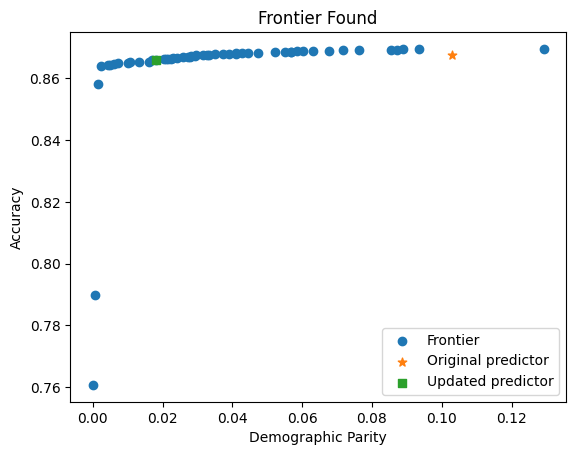

In [12]:
#To debug this, we can look at the Pareto Frontier of solutions considered, on the validation set
fpredictor.plot_frontier() 

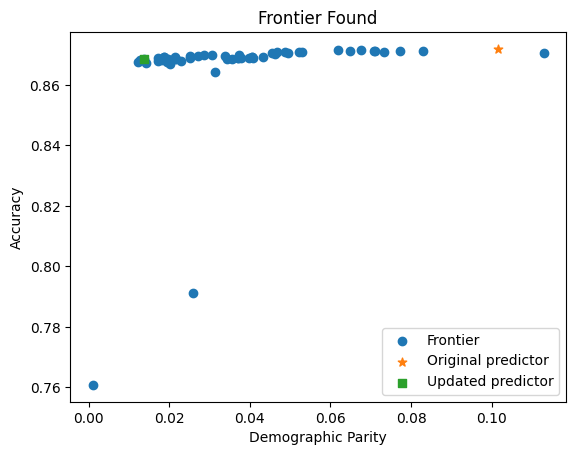

In [13]:
#and on the test set
fpredictor.plot_frontier(test_data) 

In [14]:
#We find that the demographic parity is very different on test data for a range of solutions found.
#By looking at the per group decomposition, we can find out why.
fpredictor.evaluate_groups(test_data)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.871919           0.803569  0.715326  0.635274   
         0                   0.892308           0.653390  0.461538  0.480136   
         1                   0.825193           0.761461  0.653061  0.537282   
         2                   0.932143           0.790032  0.685950  0.656913   
         3                   0.958763           0.897463  0.818182  0.794926   
         4                   0.866158           0.804588  0.720048  0.634420   
         Maximum difference  0.133570           0.244073  0.356643  0.314790   
updated  Overall             0.868479           0.777851  0.687305  0.615379   
         0                   0.884615           0.779753  0.615385  0.547813   
         1                   0.822622           0.702842  0.571429  0.497446   
         2                   0.911607           0.849944  0.681672  0.636540   
         3                   0.938144           0.925476  0.769231  0.746273   
         4                   0.864726           0.777209  0.691890  0.619732   
         Maximum difference  0.115522           0.222634  0.197802  0.248827   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.763997  0.672485  0.924047          2922.0   
         0                    0.857143  0.315789  0.893789            19.0   
         1                    0.680851  0.627451  0.867869           102.0   
         2                    0.798077  0.601449  0.958772           138.0   
         3                    0.818182  0.818182  0.973573            11.0   
         4                    0.765280  0.679864  0.921546          2652.0   
         Maximum difference   0.176292  0.502392  0.105704          2641.0   
updated  Overall              0.797200  0.604038  0.900418          2922.0   
         0                    0.600000  0.631579  0.893789            19.0   
         1                    0.779661  0.450980  0.867869           102.0   
         2                    0.612717  0.768116  0.958772           138.0   
         3                    0.666667  0.909091  0.973573            11.0   
         4                    0.817155  0.599925  0.921546          2652.0   
         Maximum difference   0.217155  0.458111  0.105704          2641.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9289.0             0.239292   
         0                            111.0             0.146154   
         1                            287.0             0.262211   
         2                            982.0             0.123214   
         3                             86.0             0.113402   
         4                           7823.0             0.253174   
         Maximum difference          7737.0             0.148809   
updated  Overall                     9289.0             0.239292   
         0                            111.0             0.146154   
         1                            287.0             0.262211   
         2                            982.0             0.123214   
         3                             86.0             0.113402   
         4                           7823.0             0.253174   
         Maximum difference          7737.0             0.148809   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.210630  
         0                                   0.053846  
         1                                   0.241645  
         2                                   0.092857  
         3                                   0.113402  
         4        

In [15]:
#The groups with the smallest Positive Prediction Rate (corresponding to American-Indian-Eskimo, and Asian-Pacific-Islander) 
# only have around 100 samples making it impossible to accurately evaluate demographic parity, while the
# group labelled 'Other' has even less data.
# Moreover, on validation data we find that there are less than 90 people identified as American-Indian-Eskimo, 
# meaning that it is not possible to predict if the positive prediction rate will hold on new data. 
fpredictor.evaluate_groups()

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.867568           0.795669  0.703900  0.621685   
         0                   0.909836           0.709316  0.560000  0.540611   
         1                   0.859459           0.816824  0.745098  0.649240   
         2                   0.924370           0.766790  0.628099  0.591542   
         3                   0.965217           0.918670  0.857143  0.837341   
         4                   0.859791           0.794180  0.705764  0.616791   
         Maximum difference  0.105758           0.209354  0.297143  0.296730   
updated  Overall             0.866093           0.772651  0.679600  0.607410   
         0                   0.877049           0.796580  0.594595  0.530414   
         1                   0.837838           0.745212  0.651163  0.579185   
         2                   0.910084           0.829788  0.646865  0.600727   
         3                   0.913043           0.888967  0.705882  0.671106   
         4                   0.861423           0.771181  0.683344  0.610987   
         Maximum difference  0.075206           0.143756  0.111288  0.140692   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.756991  0.657769  0.923969          2922.0   
         0                    0.777778  0.437500  0.916863            16.0   
         1                    0.775510  0.716981  0.928423           106.0   
         2                    0.710280  0.562963  0.949142           135.0   
         3                    0.857143  0.857143  0.960396            14.0   
         4                    0.757681  0.660505  0.919260          2651.0   
         Maximum difference   0.146862  0.419643  0.043533          2637.0   
updated  Overall              0.795048  0.593429  0.899048          2922.0   
         0                    0.523810  0.687500  0.916863            16.0   
         1                    0.848485  0.528302  0.928423           106.0   
         2                    0.583333  0.725926  0.949142           135.0   
         3                    0.600000  0.857143  0.960396            14.0   
         4                    0.816894  0.587326  0.919260          2651.0   
         Maximum difference   0.324675  0.328841  0.043533          2637.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9288.0             0.239312   
         0                            106.0             0.131148   
         1                            264.0             0.286486   
         2                           1055.0             0.113445   
         3                            101.0             0.121739   
         4                           7762.0             0.254586   
         Maximum difference          7661.0             0.173041   
updated  Overall                     9288.0             0.239312   
         0                            106.0             0.131148   
         1                            264.0             0.286486   
         2                           1055.0             0.113445   
         3                            101.0             0.121739   
         4                           7762.0             0.254586   
         Maximum difference          7661.0             0.173041   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.207944  
         0                                   0.073770  
         1                                   0.264865  
         2                                   0.089916  
         3                                   0.121739  
         4        

## Fairness on COMPAS using Inferred Attributes

We demonstrate how to enforce a wide range of fairness definitions on the COMPAS dataset. This dataset records paroles caught violating the terms of parole. As it measures who was caught, it is strongly influenced by policing and environmental biases, and should not be confused with a measurement of who actually violated their terms of parole. See [this paper](https://datasets-benchmarks-proceedings.neurips.cc/paper/2021/file/92cc227532d17e56e07902b254dfad10-Paper-round1.pdf) for a discussion of its limitations and caveats. 
We use it because it is a standard fairness dataset that captures such strong differences in outcome between people identified as African-American and everyone else, that classifiers trained on this dataset violate most definitions of fairness.

As many of the ethnic groups are too small for reliable statistical estimation, we only consider differences is in outcomes between African-Americans vs. everyone else (labeled as other).
We load and preprocess the COMPAS dataset, splitting it into three roughly equal partitions of train, validation, and test:

In [16]:
#Generate two sets of training, validation and test, with race and without.
train, val, test = dataset_loader.compas('race', train_proportion=0.66, test_proportion=0.33, discard_groups=True, replace_groups={'Hispanic':'Other', 'Native American':'Other', 'Asian':'Other'})
train_g, val_g, test_g = dataset_loader.compas('race', train_proportion=0.66, test_proportion=0.33, replace_groups={'Hispanic':'Other', 'Native American':'Other', 'Asian':'Other'})

In [17]:
predictor = xgboost.XGBClassifier().fit(X=train_g['data'],y=train_g['target'])
predictor2 = xgboost.XGBClassifier().fit(X=train['data'],y=train['target'])
protected = xgboost.XGBClassifier().fit(X=train['data'],y=2*(train['groups']=='Other')+(train['groups']=='Caucasian'))

In [18]:
fpredictor=FairPredictor(predictor2, train, inferred_groups=protected)
fpredictor.fit(gm.accuracy, gm.demographic_parity, 0.025)

In [19]:
#However, instead we will show how a family of fairness measures can be individually optimized. 
# The following code plots a table showing the change in accuracy and the fairness measure on a held-out test set as we decrease
# the fairness measure to less than 0.025 for all measures except for disparate impact which we raise to above 0.975.
# We define a helper function for evaluation:

def evaluate(fpredictor, use_metrics, test):
    "Print a table showing the accuracy drop that comes with enforcing fairness"
    extra_metrics= {**use_metrics, 'accuracy':gm.accuracy}
    collect=pd.DataFrame(columns=['Measure (original)', 'Measure (updated)', 'Accuracy (original)', 'Accuracy (updated)'])
    for d in use_metrics.items():
        if d[1].greater_is_better is False:
            fpredictor.fit(gm.accuracy,d[1], 0.025)
        else:
            fpredictor.fit(gm.accuracy,d[1], 1-0.025)
        tmp=fpredictor.evaluate_fairness(test,metrics=extra_metrics)
        collect.loc[d[1].name]=np.concatenate((np.asarray(tmp.loc[d[1].name]), np.asarray(tmp.loc[gm.accuracy.name])), 0)
    return collect

In [20]:
train['data'].columns

Index(['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'age_cat', 'c_charge_degree'],
      dtype='object')

In [21]:
#We can now contrast the behavior of a fair classifier that relies on access to the protected
# attribtute at test time with one that infers it.

#Create a fair predictor object, using the attribute 'race' on validation data
fpredictor = FairPredictor(predictor, train_g, 'race')
#and then evaluate it
true_groups = evaluate(fpredictor, gm.clarify_metrics, test_g)

true_groups

Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


,Measure (original),Measure (updated),Accuracy (original),Accuracy (updated)
Demographic Parity,0.149878,0.034548,0.653361,0.636975
Disparate Impact,0.660512,0.933217,0.653361,0.636134
Average Group Difference in Conditional Acceptance Rate,0.365188,0.105676,0.653361,0.647479
Average Group Difference in Conditional Rejectance Rate,0.071960,0.038268,0.653361,0.649160
Average Group Difference in Accuracy,0.014843,0.004748,0.653361,0.649580
Average Group Difference in Recall,0.161616,0.068086,0.653361,0.643697
Average Group Difference in Acceptance Rate,0.077211,0.100334,0.653361,0.655042
Average Group Difference in Specificity,0.102890,0.051929,0.653361,0.639916
Average Group Difference in Rejection Rate,0.057218,0.049770,0.653361,0.648319
Treatment Equality,0.244338,0.120008,0.653361,0.643697


In [22]:
 # Now using infered attributes
#Note that group information is not present in train['data']
#But contained in train['groups'] as such we can not specify groups='race'
fpredictor2 = FairPredictor(predictor2, train, inferred_groups=protected) 
inferred = evaluate(fpredictor2, gm.clarify_metrics, test)
inferred

,Measure (original),Measure (updated),Accuracy (original),Accuracy (updated)
Demographic Parity,0.135583,0.074996,0.657563,0.610084
Disparate Impact,0.698826,0.775239,0.657563,0.594538
Average Group Difference in Conditional Acceptance Rate,0.244732,0.128222,0.657563,0.634454
Average Group Difference in Conditional Rejectance Rate,0.067420,0.064152,0.657563,0.648319
Average Group Difference in Accuracy,0.055076,0.054847,0.657563,0.650000
Average Group Difference in Recall,0.118756,0.055106,0.657563,0.614706
Average Group Difference in Acceptance Rate,0.024263,0.044214,0.657563,0.655882
Average Group Difference in Specificity,0.111172,0.107794,0.657563,0.643697
Average Group Difference in Rejection Rate,0.097222,0.099675,0.657563,0.648739
Treatment Equality,0.231623,0.157130,0.657563,0.638655


In [23]:
fpredictor2.evaluate_groups(test)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.657563           0.647421  0.589007  0.301889   
         African-American    0.632486           0.633314  0.628524  0.266852   
         Caucasian           0.670370           0.627626  0.504638  0.280394   
         Other               0.715100           0.677904  0.579832  0.367683   
         Maximum difference  0.082614           0.050277  0.123886  0.100831   
updated  Overall             0.638655           0.627870  0.563895  0.262470   
         African-American    0.616899           0.618162  0.606571  0.237010   
         Caucasian           0.650617           0.609137  0.482633  0.237142   
         Other               0.686610           0.647058  0.537815  0.303932   
         Maximum difference  0.069711           0.037921  0.123939  0.066922   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.641758  0.544268  0.697111          1073.0   
         African-American     0.654577  0.604466  0.683172           627.0   
         Caucasian            0.618182  0.426332  0.675842           319.0   
         Other                0.621622  0.543307  0.729436           127.0   
         Maximum difference   0.036395  0.178133  0.053594           500.0   
updated  Overall              0.618465  0.518173  0.675213          1073.0   
         African-American     0.642857  0.574163  0.663147           627.0   
         Caucasian            0.578947  0.413793  0.654135           319.0   
         Other                0.576577  0.503937  0.707185           127.0   
         Maximum difference   0.066281  0.160370  0.053050           500.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     1307.0             0.450840   
         African-American             592.0             0.514356   
         Caucasian                    491.0             0.393827   
         Other                        224.0             0.361823   
         Maximum difference           368.0             0.152533   
updated  Overall                     1307.0             0.450840   
         African-American             592.0             0.514356   
         Caucasian                    491.0             0.393827   
         Other                        224.0             0.361823   
         Maximum difference           368.0             0.152533   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.382353  
         African-American                    0.474979  
         Caucasian                           0.271605  
         Other                               0.316239  
         Maximum difference                  0.203375  
updated  Overall                             0.377731  
         African-American                    0.459393  
         Caucasian                           0.281481  
         Other                               0.316239  
         Maximum difference                  0.177911

In [24]:
from oxonfair import conditional_group_metrics as cgm
fpredictor2_cond = FairPredictor(predictor2, train, inferred_groups=protected,conditioning_factor='sex') 
fpredictor2_cond.fit(gm.accuracy,cgm.pos_pred_rate.diff,0.02)

In [25]:
fpredictor2_cond.evaluate(metrics={'a':gm.accuracy,'b':cgm.pos_pred_rate.diff})


,original,updated
Accuracy,0.747165,0.678706
Average Group Difference in Conditional Positive Prediction Rate,0.140569,0.019400


In [26]:
fpredictor2_cond.evaluate(test,metrics={'a':gm.accuracy,'b':cgm.pos_pred_rate.diff})


,original,updated
Accuracy,0.657563,0.610084
Average Group Difference in Conditional Positive Prediction Rate,0.130682,0.071482
